In [138]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import os
import rasterio as rio
from affine import Affine
from pyproj import CRS
from utils import vert_interp, read_raster, local_density, get_reproj_bounds, read_limited_raster
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from scipy.stats import pearsonr
from scipy.interpolate import griddata
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import itertools as it


path_data = os.path.join(os.environ['PROJDIR'], 'ERW_LDRD', 'data')
path_out = os.path.join(os.environ['PROJDIR'], 'ERW_LDRD', 'results')

recollect_predictors = False # if true, re-read predictors data from geotiff (takes long time)

elm_bot = 100 * np.array([0.0175, 0.0451, 0.0906, 0.1655, 0.2891, 0.4929, 0.8289, 
                          1.3828, 2.2961, 3.8019])
elm_top = np.insert(elm_bot[:-1], 0, 0)
elm_nodes = np.array([0.0071, 0.0279, 0.0623, 0.1189, 0.2122, 0.3661, 0.6198, 1.0380, 1.7276, 
                      2.8646])

In [ ]:
if recollect_predictors:
    ###########################################################
    # Read and intersect the valid data
    ###########################################################
    lab_chemical_properties = pd.read_csv(
        os.path.join(path_data, 'NCSSLabDataMart_MSAccess', 'lab_chemical_properties_vw.csv')
    ).set_index('layer_key')[['ca_nh4_ph_7', 'ca_nh4_ph_7_method', 
                              'mg_nh4_ph_7', 'mg_nh4_ph_7_method', 
                              'na_nh4_ph_7', 'na_nh4_ph_7_method', 
                              'k_nh4_ph_7', 'k_nh4_ph_7_method',
                              'acidity_bacl2_tea_ph_8_2', 'acidity_bacl2_tea_ph_82_method',
                              'aluminum_kcl_extractable', 'aluminum_kcl_extract_method', 
                              'cec_nh4_ph_7', 'cec_nh4_ph_7_method']]

    layer_properties = pd.read_csv(
        os.path.join(path_data, 'NCSSLabDataMart_MSAccess', 'ncss_labdata_lab_layer.csv')
    )[['layer_key', 'site_key', 'hzn_top', 'hzn_bot']].set_index('layer_key')
    layer_properties['hzn_node'] = layer_properties[['hzn_top', 'hzn_bot']].mean(axis = 1)
    layer_properties['hzn_thickness'] = layer_properties['hzn_bot'] - layer_properties['hzn_top']
    # remove invalid and negative layers
    layer_properties = layer_properties.dropna(axis = 0, how = 'any')
    layer_properties = layer_properties.query('hzn_top >= 0. and hzn_thickness >= 0.')
    layer_properties['site_key'] = layer_properties['site_key'].astype(np.int64)

    # layer that has a site key
    common_layers = lab_chemical_properties.index.intersection(layer_properties.index)
    lab_chemical_properties = lab_chemical_properties.loc[common_layers, :]
    layer_properties = layer_properties.loc[common_layers, :]

    site_coords = pd.read_csv(
        os.path.join(path_data, 'NCSSLabDataMart_MSAccess', 'lab_site.csv')
    )[['site_key', 'latitude_std_decimal_degrees', 
    'longitude_std_decimal_degrees']].set_index('site_key')

    # remove sites without coordinates / outside the US
    site_coords = site_coords.dropna(axis = 0, how = 'any')
    site_coords = site_coords.query(
        'latitude_std_decimal_degrees >= 25 and latitude_std_decimal_degrees <= 50 and longitude_std_decimal_degrees >= -130 and longitude_std_decimal_degrees <= -65'
    )

    # site that has a lat lon
    valid_layers = layer_properties['site_key'].isin(site_coords.index)
    lab_chemical_properties = lab_chemical_properties.loc[valid_layers, :]
    layer_properties = layer_properties.loc[valid_layers, :]

    # add site info to the lab chemical properties
    layer_to_site = layer_properties['site_key'].to_dict()
    lab_chemical_properties['site_key'] = [layer_to_site[i] for i in lab_chemical_properties.index]
    lab_chemical_properties['lat'] = [site_coords.loc[layer_to_site[i], 'latitude_std_decimal_degrees'] for i in lab_chemical_properties.index]
    lab_chemical_properties['lon'] = [site_coords.loc[layer_to_site[i], 'longitude_std_decimal_degrees'] for i in lab_chemical_properties.index]
    lab_chemical_properties['hzn_top'] = [layer_properties.loc[i, 'hzn_top'] for i in lab_chemical_properties.index]
    lab_chemical_properties['hzn_bot'] = [layer_properties.loc[i, 'hzn_bot'] for i in lab_chemical_properties.index]

In [ ]:
if recollect_predictors:
    ###########################################################
    # only keep the pendons that have complete profiles
    # - note: use copy() to avoid passing by reference
    # 'acidity_bacl2_tea_ph_8_2', 'acidity_bacl2_tea_ph_82_method', 
    ###########################################################
    subset = ['ca_nh4_ph_7', 'ca_nh4_ph_7_method', 'mg_nh4_ph_7',
            'mg_nh4_ph_7_method', 'na_nh4_ph_7', 'na_nh4_ph_7_method', 
            'k_nh4_ph_7', 'k_nh4_ph_7_method', 'aluminum_kcl_extractable',
            'aluminum_kcl_extract_method', 'cec_nh4_ph_7', 'cec_nh4_ph_7_method']

    lab_chemprop_complete = lab_chemical_properties.dropna(axis = 0, how = 'any', subset = subset).copy()

    # subtract the Al3+ from acid CEC
    lab_chemprop_complete.loc[:, 'acidity_bacl2_tea_ph_8_2'] = \
        lab_chemprop_complete['acidity_bacl2_tea_ph_8_2'].values - \
        lab_chemprop_complete['aluminum_kcl_extractable'].values

    # reset the <0 values to 0
    for col in ['ca_nh4_ph_7', 'mg_nh4_ph_7', 'na_nh4_ph_7', 'k_nh4_ph_7', 'acidity_bacl2_tea_ph_8_2']:
        lab_chemprop_complete.loc[lab_chemprop_complete[col] <= 0, col] = 0.

    # sort the vertical depths
    lab_chemprop_complete = lab_chemprop_complete.groupby('site_key', group_keys = True).apply(lambda df: df.sort_values(by = 'hzn_top'))

In [ ]:
if recollect_predictors:
    ###########################################################
    # Filter data to only when total CEC < sum of bases and Al
    ###########################################################

    # convert the CEC values to total CEC and fractions
    lab_newdata = pd.DataFrame(np.nan, index = lab_chemprop_complete.index, 
                            columns = ['CEC_tot', 'beta_Ca', 'beta_Mg', 'beta_Na', 'beta_K', 
                                        'beta_Al', 'lat', 'lon', 'hzn_top', 'hzn_bot'])
    lab_newdata.loc[:, 'CEC_tot'] = lab_chemprop_complete['cec_nh4_ph_7'].copy()
    #    lab_chemprop_complete['ca_nh4_ph_7'] + \
    #    lab_chemprop_complete['mg_nh4_ph_7'] + lab_chemprop_complete['na_nh4_ph_7'] + \
    #    lab_chemprop_complete['k_nh4_ph_7'] + lab_chemprop_complete['aluminum_kcl_extractable'] + \
    #    lab_chemprop_complete['acidity_bacl2_tea_ph_8_2']
    lab_newdata.loc[:, 'beta_Ca'] = lab_chemprop_complete['ca_nh4_ph_7'] / lab_newdata['CEC_tot']
    lab_newdata.loc[:, 'beta_Mg'] = lab_chemprop_complete['mg_nh4_ph_7'] / lab_newdata['CEC_tot']
    lab_newdata.loc[:, 'beta_Na'] = lab_chemprop_complete['na_nh4_ph_7'] / lab_newdata['CEC_tot']
    lab_newdata.loc[:, 'beta_K'] = lab_chemprop_complete['k_nh4_ph_7'] / lab_newdata['CEC_tot']
    lab_newdata.loc[:, 'beta_Al'] = lab_chemprop_complete['aluminum_kcl_extractable'] / lab_newdata['CEC_tot']

    # reset the < 0 value to 1e-3
    lab_newdata.loc[:, 'beta_Ca'] = lab_newdata['beta_Ca'].clip(lower = 0.001)
    lab_newdata.loc[:, 'beta_Mg'] = lab_newdata['beta_Mg'].clip(lower = 0.001)
    lab_newdata.loc[:, 'beta_Na'] = lab_newdata['beta_Na'].clip(lower = 0.001)
    lab_newdata.loc[:, 'beta_K'] = lab_newdata['beta_K'].clip(lower = 0.001)
    lab_newdata.loc[:, 'beta_Al'] = lab_newdata['beta_Al'].clip(lower = 0.001)

    lab_newdata = lab_newdata.loc[lab_newdata[['beta_Ca','beta_Mg','beta_Na','beta_K','beta_Al']].sum(axis = 1) < 1, :]

    # remove the values where CEC_tot = 0
    lab_newdata = lab_newdata.loc[lab_newdata['CEC_tot'] > 1e-8, :]

    lab_newdata.loc[:,['lat', 'lon', 'hzn_top', 'hzn_bot']] = \
        lab_chemprop_complete.loc[:,['lat', 'lon', 'hzn_top', 'hzn_bot']]

    lab_newdata = lab_newdata.reset_index()

    print('total number of original available sites = ', 
          len(lab_newdata['site_key'].drop_duplicates()))

    lab_newdata

In [ ]:
if False:
    ##################################################################################
    # Vertical interpolation: in order to preserve vertical consistency between 
    # layers, focus on each individual site, instead of all the sites
    ##################################################################################
    def process_site_data(subset, colname):

        # Skip if the site does not have complete data between 5cm and 95cm
        subset = subset.sort_values(by = 'hzn_top', axis = 0)
        if (subset['hzn_top'].iloc[0] > 5) or (subset['hzn_bot'].iloc[-1] < 95):
            return pd.Series([])
        if subset.shape[0] == 0:
            return pd.Series([])
        elif subset.shape[0] == 1:
            return pd.Series(subset[col].iloc[0], index = range(len(elm_top)))
        else:
            if np.max(np.abs(subset['hzn_top'].iloc[1:].values - \
                            subset['hzn_bot'].iloc[:-1].values)) > 0.1:
                return pd.Series([])

            # Perform interpolation when the data is good
            # (if the deepest layer is only 100cm, fill >100cm using available deepest layer's data)
            target_nodes = (elm_bot + elm_top) / 2
            input_nodes = subset[['hzn_bot','hzn_top']].mean(axis = 1).values
            input_data = subset[colname].values.reshape(1, -1)
            target_single_level = False
            target_interfaces = np.insert(elm_bot, 0, 0)
            input_interfaces = np.insert(subset['hzn_bot'].values, 0, subset['hzn_top'].iloc[0])

            result = vert_interp(target_nodes, input_nodes, input_data, target_single_level, 
                                target_interfaces, input_interfaces)
            return pd.Series(result.reshape(-1), index = range(len(elm_top)))

    xlswriter = pd.ExcelWriter(os.path.join(path_out, 'interp_NCSS.xlsx'), engine='openpyxl')
    for col in ['CEC_tot', 'beta_Ca', 'beta_Mg', 'beta_Na', 'beta_K', 'beta_Al']:
        interpolated = lab_newdata.groupby('site_key').apply(process_site_data, colname = col)
        interpolated = interpolated.unstack()
        interpolated.columns = [f'{elm_top[i]:.4f}-{elm_bot[i]:.4f}' for i in range(len(elm_top))]
        coords = lab_newdata[['site_key', 'lat', 'lon']].drop_duplicates().set_index('site_key')
        interpolated['lat'] = coords.loc[interpolated.index, 'lat']
        interpolated['lon'] = coords.loc[interpolated.index, 'lon']
        interpolated.to_excel(xlswriter, sheet_name = col)
    xlswriter.close()

In [ ]:
##################################################################################
# Collect the predictors and predictand data, this takes a long time, so I saved to 
# .csv and read as needed
##################################################################################
if recollect_predictors:
    data = lab_newdata
    data['hzn_mid'] = (data['hzn_top'] + data['hzn_bot']) / 2

    # Read the soil properties predictors from SSURGO
    lat_list, lon_list = data['lat'], data['lon']

    # verified that cec and soil organic matter are not useful! 
    # mean_ksat is marginal: only decreased by 0.001
    # rf_025 surprisingly useful
    # ph_025 also not useful
    ssurgo_file_list = ['caco3_kg_sq_m', 'db', 'soil_depth', 'rf_025',
                        'ph', 'ph_05', 'ph_025', 'ph_3060',
                        'sand', 'sand_05', 'sand_025', 'sand_3060',
                        'clay', 'clay_05', 'clay_025', 'clay_3060']
    for file in ssurgo_file_list:
        src_file = os.path.join(os.environ['PROJDIR'], 'ERW_LDRD', 'data', 'SSURGO', f'{file}.tif')
        data.loc[:, file] = read_raster(src_file, lat_list, lon_list, 1)

    data.loc[:, 'caco3_kg_sq_m'] = np.log(data['caco3_kg_sq_m'] + 1)

    src_file = os.path.join(os.environ['PROJDIR'], 'ERW_LDRD', 'data', 
                            'USGS_3DEP_800m_EPSG5070.tif')
    data.loc[:, 'elevation'] = read_raster(src_file, lat_list, lon_list, 1)

    # Read the meteorological properties
    src_file = os.path.join(os.environ['PROJDIR'], 'ERW_LDRD', 'data', 
                            'DAYMET_V4_Climatology_1980_2010.tif')
    data.loc[:, 'prcp'] = read_raster(src_file, lat_list, lon_list, 1)
    data.loc[:, 'tmax'] = read_raster(src_file, lat_list, lon_list, 2)
    data.loc[:, 'tmin'] = read_raster(src_file, lat_list, lon_list, 3)

    # Land cover - average NLCD 2001, 2004, 2006, 2008
    luc_list = ['other', 'developed', 'barren', 'forested_upland', 'herbaceous_upland',
                'shrubland', 'cultivated']
    for band, luc in enumerate(luc_list, 1):
        data.loc[:, luc] = 0.
        for i, year in enumerate([2001, 2004, 2006, 2008]):
            src_file = os.path.join(os.environ['PROJDIR'], 'ERW_LDRD', 'data', 'NLCD', 
                                    f'NLCD_{year}.tif')
            data.loc[:, luc] = data.loc[:, luc] + read_raster(src_file, lat_list, lon_list, band)
        data.loc[:, luc] /= 4

    data.to_csv(os.path.join(path_out, 'interp_NCSS_RF_temp.csv'))

In [ ]:
##################################################################################
# Try fitting the random forest model using the original data, regardless of
# vertical depths
##################################################################################
data = pd.read_csv(os.path.join(path_out, 'interp_NCSS_RF_temp.csv'), index_col = 0)

data2 = data.dropna(axis = 0, how = 'any').drop(
    ['site_key', 'layer_key', 'hzn_top', 'hzn_bot', 'CEC_tot'], axis = 1)

# The beta values add up to 1
y = data2[['beta_Ca', 'beta_Mg', 'beta_Na', 'beta_K', 'beta_Al']]
y['beta_H'] = 1 - y.sum(axis = 1)

# 'caco3_kg_sq_m', 'soil_depth', 'barren', 'developed', 
numeric_features = ['lat', 'lon', 'hzn_mid', 'db', 'soil_depth', 
                    'rf_025', 'ph', 'ph_05', 'ph_025', 'ph_3060', 
                    'sand', 'sand_05', 'sand_3060', # 'sand_025', 
                    'clay', 'clay_025', 'clay_3060', # 'clay_05', 
                    'elevation', 'prcp', 'tmax', # 'tmin',
                    'other', 'forested_upland', 
                    'herbaceous_upland', 'shrubland', 'cultivated']

X = data2[numeric_features]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Create the y-transformer
# Create and fit the model with the preprocessor
model = TransformedTargetRegressor(
    RandomForestRegressor(random_state=42, n_estimators=400, n_jobs=-1),
    # func = np.log1p, inverse_func = np.expm1
)
pipeline = Pipeline([
    ('regressor', model)
])
def normalize_predictions(predictions):
    return predictions / predictions.sum(axis=1, keepdims=True)

# Fit the pipeline
pipeline.fit(X_train, y_train)
y_pred_train = normalize_predictions(pipeline.predict(X_train))
y_pred_test = normalize_predictions(pipeline.predict(X_test))

In [ ]:
##################################################################################
# Plot the diagnostics of the random forest model
##################################################################################
# Plot the importance
fig, ax = plt.subplots( figsize = (8, 6))
importance = pipeline.named_steps['regressor'].regressor_.feature_importances_
ax.bar(np.arange(len(importance)), importance)
ax.set_xticks(np.arange(len(importance)))
ax.set_xticklabels(X.columns, rotation = 90)
r2_test = pipeline.score(X_test, y_test)
ax.text(0.6, 0.8, '$R^2_{test}$'+f'={r2_test:.3f}', transform = ax.transAxes)


fig, axes = plt.subplots(2, 3, figsize = (16, 12))
# Plot the predicted value against observed value
for i, col in enumerate(y.columns):
    ax = axes.flat[i]

    # Performance metric
    rho_test, _ = pearsonr(y_pred_test[:, i], y_test[col].values)

    x_, y_, z = local_density(y_pred_test[:, i], y_test[col].values)
    ax.scatter(x_, y_, c = z, cmap = 'Spectral', s = 3, alpha = 0.3, label = 'Test')
    #ax.set_xscale('log')
    #ax.set_yscale('log')

    ax.text(0.1, 0.8, r'$\rho$' + '$_{test}$' + f'={rho_test:.3f}', transform = ax.transAxes)
    ax.set_xlabel(f'Predicted {col} (%)')
    ax.set_ylabel(f'Observed {col} (%)')

In [ ]:
##################################################################################
# Read predictors from reprojected files created in "interp_soilMineral_RF.ipynb"
##################################################################################
collect_data = {}

overlap_bounds = get_reproj_bounds()

# Create arrays to store the coordinates
data = read_limited_raster(os.path.join(os.environ['PROJDIR'], 'ERW_LDRD', 'data', 'SSURGO', 
                                        'reproj_caco3_kg_sq_m.tif'), 1, overlap_bounds)
height = data.shape[0]
width = data.shape[1]
lons = np.zeros((height, width))
lats = np.zeros((height, width))

# Get the CONUS lat & lon from the reprojected geotiff files
h = rio.open(os.path.join(os.environ['PROJDIR'], 'ERW_LDRD', 'data', 'SSURGO',
                          'reproj_caco3_kg_sq_m.tif'))
transform = h.transform
for row in range(height):
    for col in range(width):
        x, y = rio.transform.xy(transform, row, col)
        lons[row, col] = x
        lats[row, col] = y
h.close()

collect_data['lat'] = lats
collect_data['lon'] = lons

# Cut the elevation data to the same extent of the CEC files
collect_data['elevation'] = read_limited_raster( \
    os.path.join(os.environ['PROJDIR'], 'ERW_LDRD', 'data',
                 'reproj_USGS_3DEP_800m_EPSG5070.tif'), 1, overlap_bounds)

# Daymet meteorological variables - cut to SSURGO extent
collect_data['prcp'] = read_limited_raster( \
    os.path.join(os.environ['PROJDIR'], 'ERW_LDRD', 'data',
                 'reproj_DAYMET_V4_Climatology_1980_2010.tif'), 1, overlap_bounds)
collect_data['tmax'] = read_limited_raster( \
    os.path.join(os.environ['PROJDIR'], 'ERW_LDRD', 'data',
                 'reproj_DAYMET_V4_Climatology_1980_2010.tif'), 2, overlap_bounds)
collect_data['tmin'] = read_limited_raster( \
    os.path.join(os.environ['PROJDIR'], 'ERW_LDRD', 'data',
                 'reproj_DAYMET_V4_Climatology_1980_2010.tif'), 3, overlap_bounds)

# Land cover - average NLCD 2001, 2004, 2006, 2008
luc_list = ['other', 'developed', 'barren', 'forested_upland', 'herbaceous_upland',
            'shrubland', 'cultivated']
pct_luc = np.full([7, height, width], np.nan)
for j, name in enumerate(luc_list): 
    temp = np.full([4, height, width], np.nan)
    for i, year in enumerate([2001, 2004, 2006, 2008]):
        path_luc = os.path.join(os.environ['PROJDIR'], 'ERW_LDRD', 'data', 
                                'NLCD', f'reproj_NLCD_{year}.tif')
        temp[i, :, :] = read_limited_raster(path_luc, j+1, overlap_bounds)
        h.close()
    pct_luc[j, :, :] = np.nanmean(temp, axis = 0)
for j, name in enumerate(luc_list):
    collect_data[name] = pct_luc[j, :, :]

# SSURGO maps
ssurgo_file_list = ['caco3_kg_sq_m', 'db', 'soil_depth', 'rf_025',
                    'ph', 'ph_05', 'ph_025', 'ph_3060',
                    'sand', 'sand_05', 'sand_025', 'sand_3060',
                    'clay', 'clay_05', 'clay_025', 'clay_3060']
for file in ssurgo_file_list:
    collect_data[file] = read_limited_raster(os.path.join(os.environ['PROJDIR'], 
        'ERW_LDRD', 'data', 'SSURGO', f'reproj_{file}.tif'), 1, overlap_bounds)

# re-form into pandas data frame
for key in collect_data.keys():
    collect_data[key] = collect_data[key].reshape(-1)
collect_data = pd.DataFrame(collect_data)

# subset to only valid points for prediction
invalid_locations = collect_data.isna().sum(axis = 1) > 0
collect_data_valid = collect_data.loc[~invalid_locations, :]

In [140]:
##################################################################################
# Apply the fitted random forest model to predict the soil map
# 
# Interestingly, the top 5 layers have little variation. Probably because 
# not enough data and shallow difference. 
##################################################################################
predicted_map = np.full([len(elm_nodes), 6, height, width], np.nan)

for i, hzn_mid in enumerate(elm_nodes):
    # Insert the horizon depth into the predictor
    collect_data_valid.loc[:, 'hzn_mid'] = hzn_mid
    # Re-format depending on which variable
    X = collect_data_valid.loc[:, numeric_features]
    y_pred = pipeline.predict(X)
    temp = np.full([6, len(invalid_locations)], np.nan)
    temp[:, ~invalid_locations] = y_pred.T

    predicted_map[i, :, :, :] = temp.reshape([6, height, width])

In [141]:
##################################################################################
# Save the predicted info to geotiff; put each cation into the same file to
# make it easy to catch sum = 1 errors
##################################################################################
# note the affine is different from the reprojected files, with the subset to only overlapping areas
kwargs = {'driver': 'GTiff', 'dtype': 'float32', 'nodata': -9999.0, 'width': width,
          'height': height, 'count': predicted_map.shape[0], 'crs': CRS.from_epsg(4326), 
          'transform': Affine(0.1, 0.0, overlap_bounds[0], 0.0, -0.1, overlap_bounds[-1])}

for i in range(predicted_map.shape[0]):
    with rio.open(os.path.join(os.environ['PROJDIR'], 'ERW_LDRD', 'results', 
                                f'RF_NCSS_layer_{i}.tif'), 'w', **kwargs) as dst:
        for j, name in enumerate(['beta_Ca', 'beta_Mg', 'beta_Na', 'beta_K', 'beta_Al', 'beta_H']):
            dst.write(predicted_map[i,j], j + 1) # Band indexing in rasterio starts at 1
h.close()

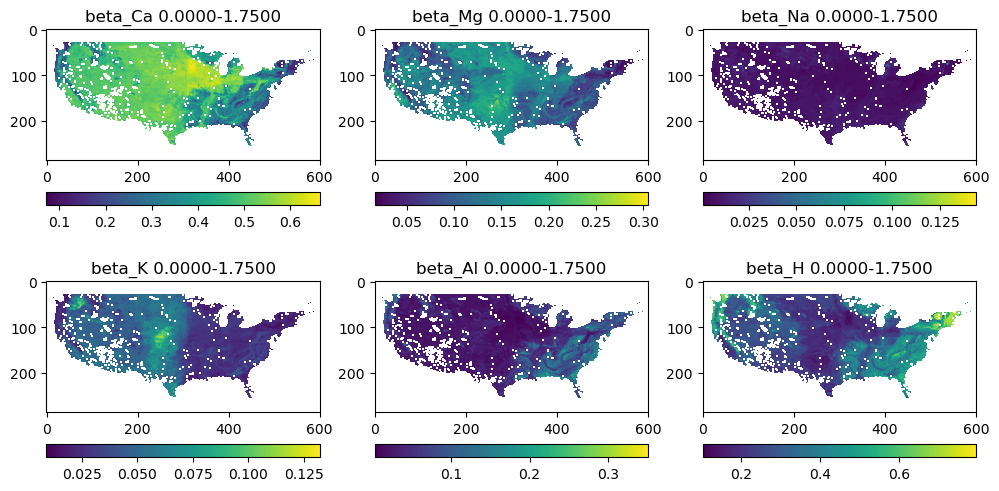

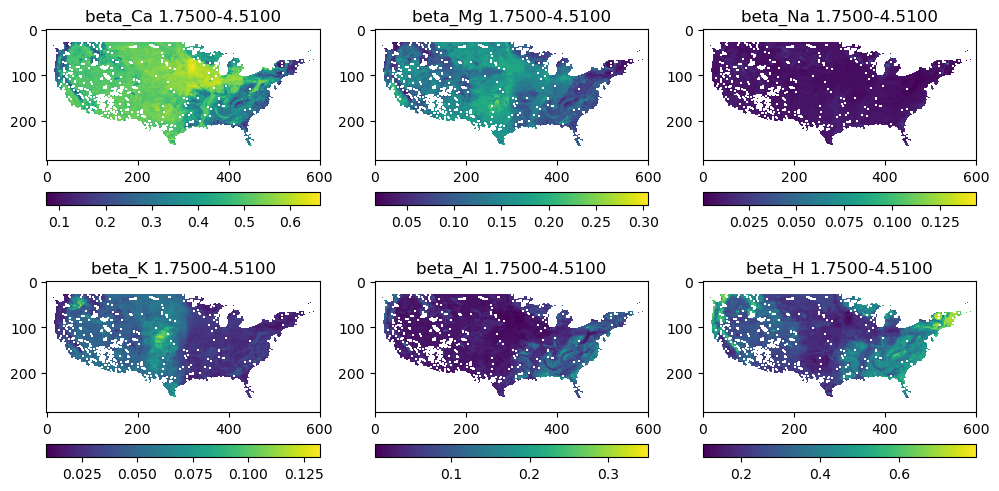

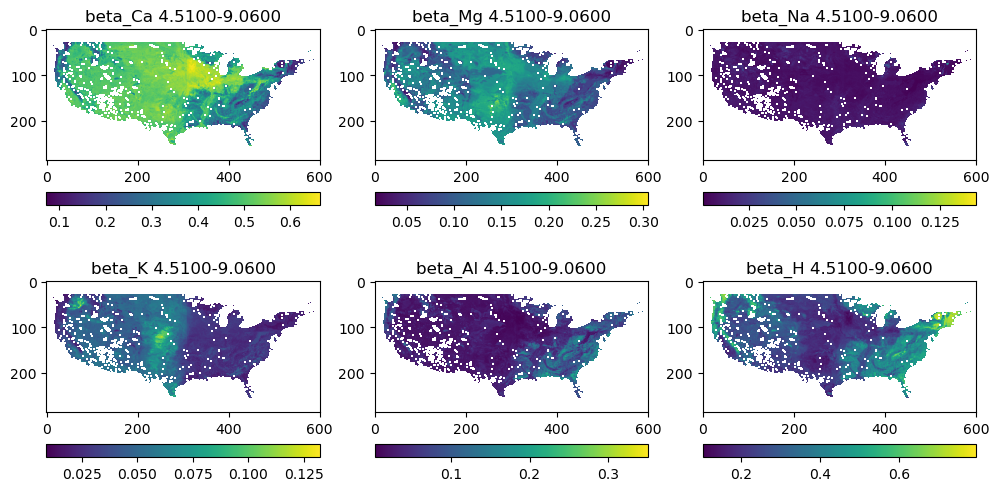

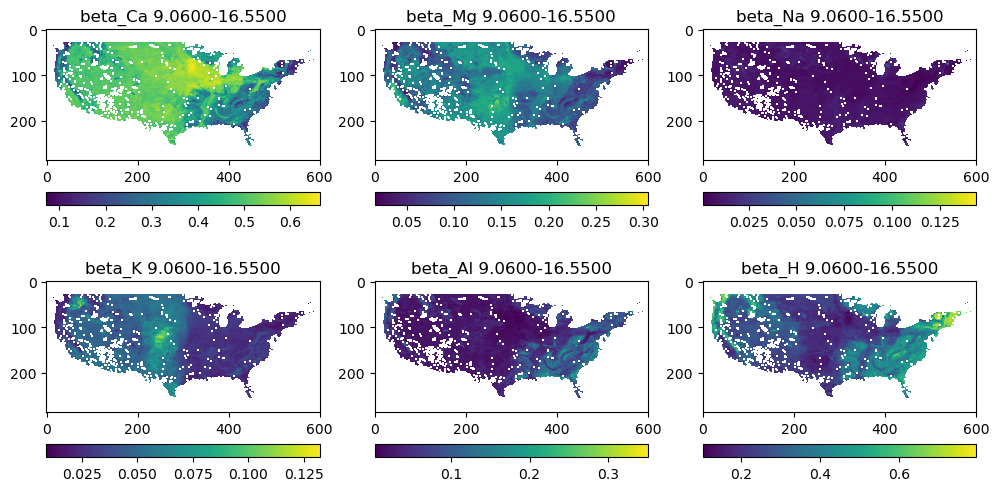

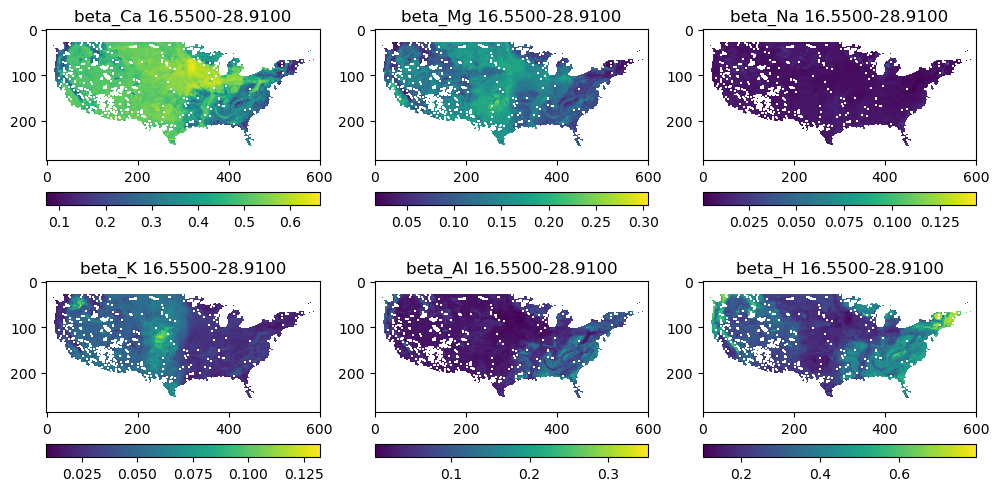

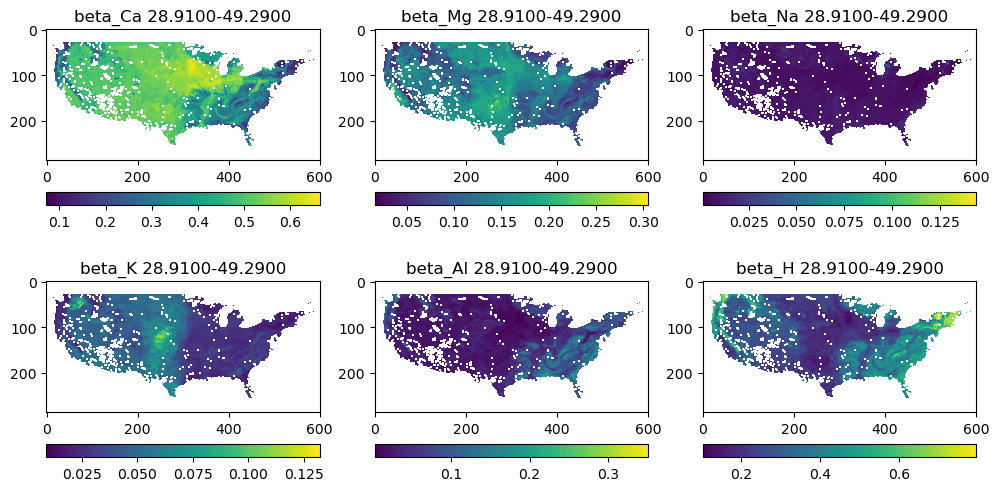

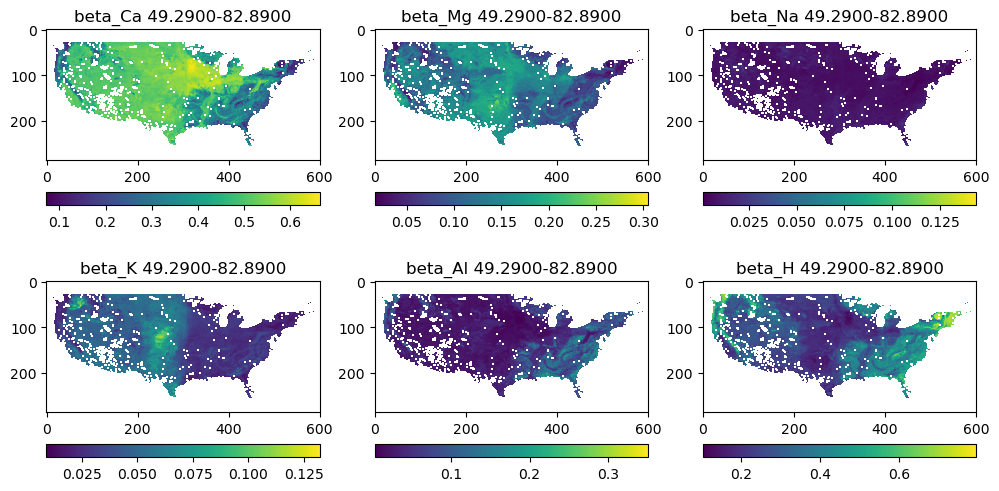

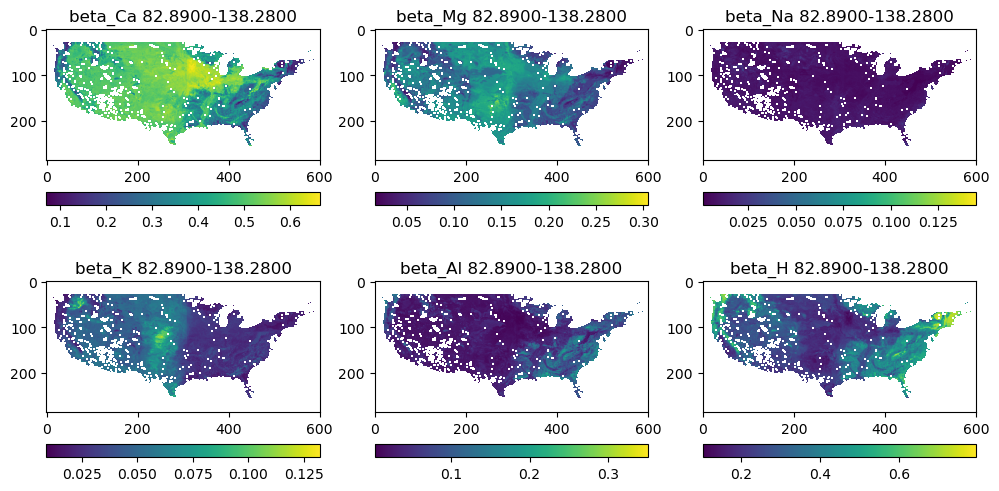

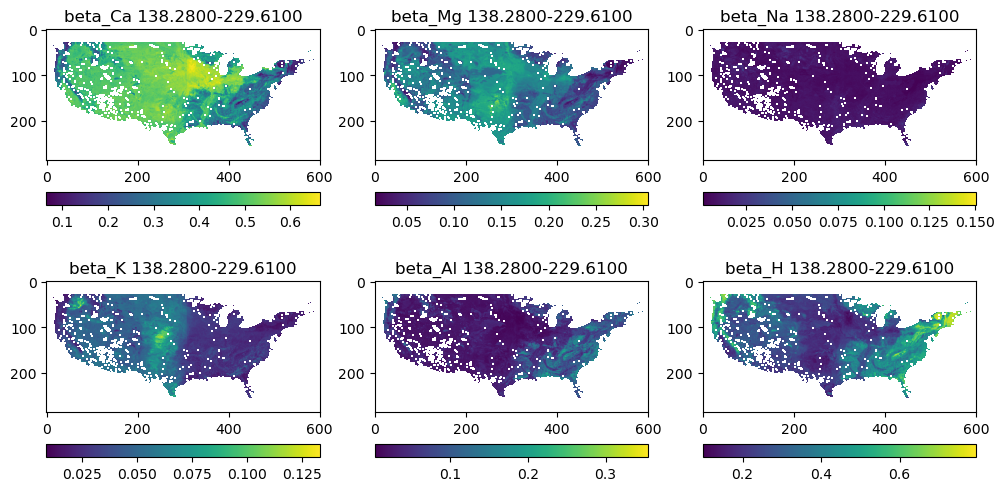

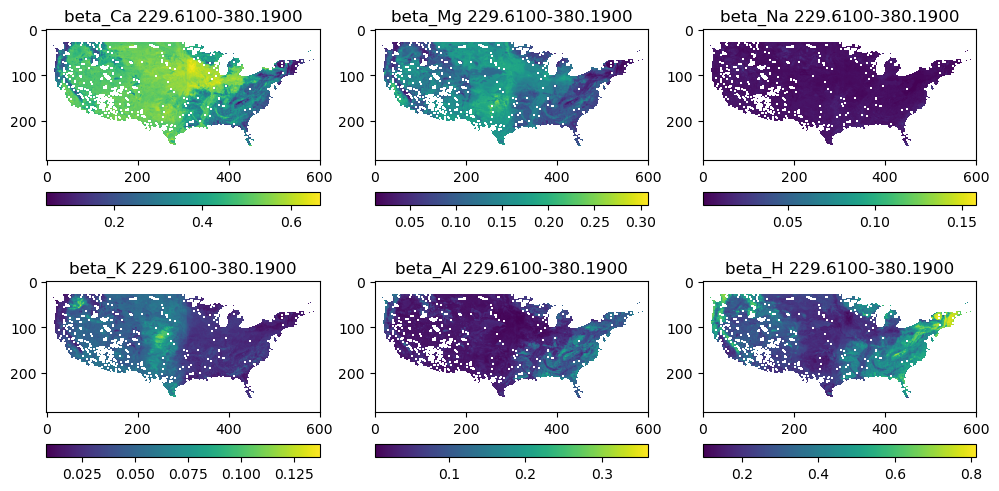

In [142]:
##################################################################################
# Visualize the predicted maps
#
# Still need to fix the holes in QGIS - Processing Toolbox - GRASS - Raster - r.fill.stats
# Make sure to check "preserve original cell values" to prevent original values from being smoothed
# See `interp_NCSS_RF_QGIS.py` for the python code to run in QGIS console
##################################################################################
for i in range(10):
    h = rio.open(os.path.join(os.environ['PROJDIR'], 'ERW_LDRD', 'results', 
                              f'RF_NCSS_layer_{i}.tif'))
    fig, axes = plt.subplots(2, 3, figsize = (12, 6))
    for j, name in enumerate(['beta_Ca', 'beta_Mg', 'beta_Na', 'beta_K', 'beta_Al', 'beta_H']):
        ax = axes.flat[j]
        cf = ax.imshow(h.read(j+1))
        plt.colorbar(cf, ax = ax, orientation = 'horizontal')
        ax.set_title(f'{name} {elm_top[i]:.4f}-{elm_bot[i]:.4f}')

    h.close()

In [146]:
##################################################################################
# Interpolate to 0.5 degrees with more gap-filling and normalization to 1
##################################################################################
lats_target = np.arange(23.25, 54.26, 0.5)
lons_target = np.arange(234.75, 293.26, 0.5) - 360.
ds = np.full([10, 6, len(lats_target), len(lons_target)], np.nan)

for layer in range(10):
    h = rio.open(os.path.join(os.environ['PROJDIR'], 'ERW_LDRD', 'results', 
                            f'RF_NCSS_layer_{layer}_filled.tif'))

    # tif file is in EPSG:5070
    left, bottom, right, top = h.bounds
    rows, cols = np.indices(h.shape)
    src_x, src_y = rio.transform.xy(h.transform, rows, cols)
    lons = np.array(src_x)
    lats = np.array(src_y)

    # conduct reprojection
    lons_mesh, lats_mesh = np.meshgrid(lons_target, lats_target)
    src_coords = np.array([lons.flatten(), lats.flatten()]).T

    # read data and fill the ds matrix
    for band in range(1, 7):
        data = h.read(band, masked = True)
        src_data_flat = data.flatten()

        data_reproj = griddata(src_coords, src_data_flat, (lons_mesh, lats_mesh),
                               method='linear')
        # use the nearest neighbor for the NE patch of missing data
        search_rows, search_cols = np.where(~np.isnan(data_reproj))
        for row, col in it.product(range(45, 49), range(110, 114)):
            if (row == 48) and (col == 110 or col == 111):
                continue
            if (row == 47) and col == 110:
                continue
            if np.isnan(data_reproj[row,col]):
                ind = np.argmin(np.power(search_rows-row,2) + np.power(search_cols-col,2))
                find_row, find_col = search_rows[ind], search_cols[ind]
                data_reproj[row,col] = data_reproj[find_row, find_col]
        # data_reproj[45, 109] = data_reproj[45, 110] """
        ds[layer, band-1, :, :] = data_reproj
    h.close()

# re-adjust the sum of beta's to 1
ds = ds / np.nansum(ds, axis = 1, keepdims = True)

# save to netcdf
ds2 = xr.Dataset()
for band, name in enumerate(['beta_Ca', 'beta_Mg', 'beta_Na', 'beta_K', 'beta_Al', 'beta_H']):
    ds2[name] = xr.DataArray(ds[:, band, :, :], coords = {'lat': lats_target, 'lon': lons_target}, 
                             dims = ['nlevsoi','lat','lon'])
filename = os.path.join(os.environ['PROJDIR'], 'ERW_LDRD', 'results', 
                        f'RF_NCSS_filled_interp.nc')
if os.path.exists(filename):
    os.remove(filename)
ds2.to_netcdf(filename)

1.0000000000000004 0.9999999999999997
1.0000000000000004 0.9999999999999997
1.0000000000000004 0.9999999999999997
1.0000000000000004 0.9999999999999997
1.0000000000000004 0.9999999999999997
1.0000000000000004 0.9999999999999997
1.0000000000000004 0.9999999999999997
1.0000000000000004 0.9999999999999997
1.0000000000000004 0.9999999999999997
1.0000000000000004 0.9999999999999996


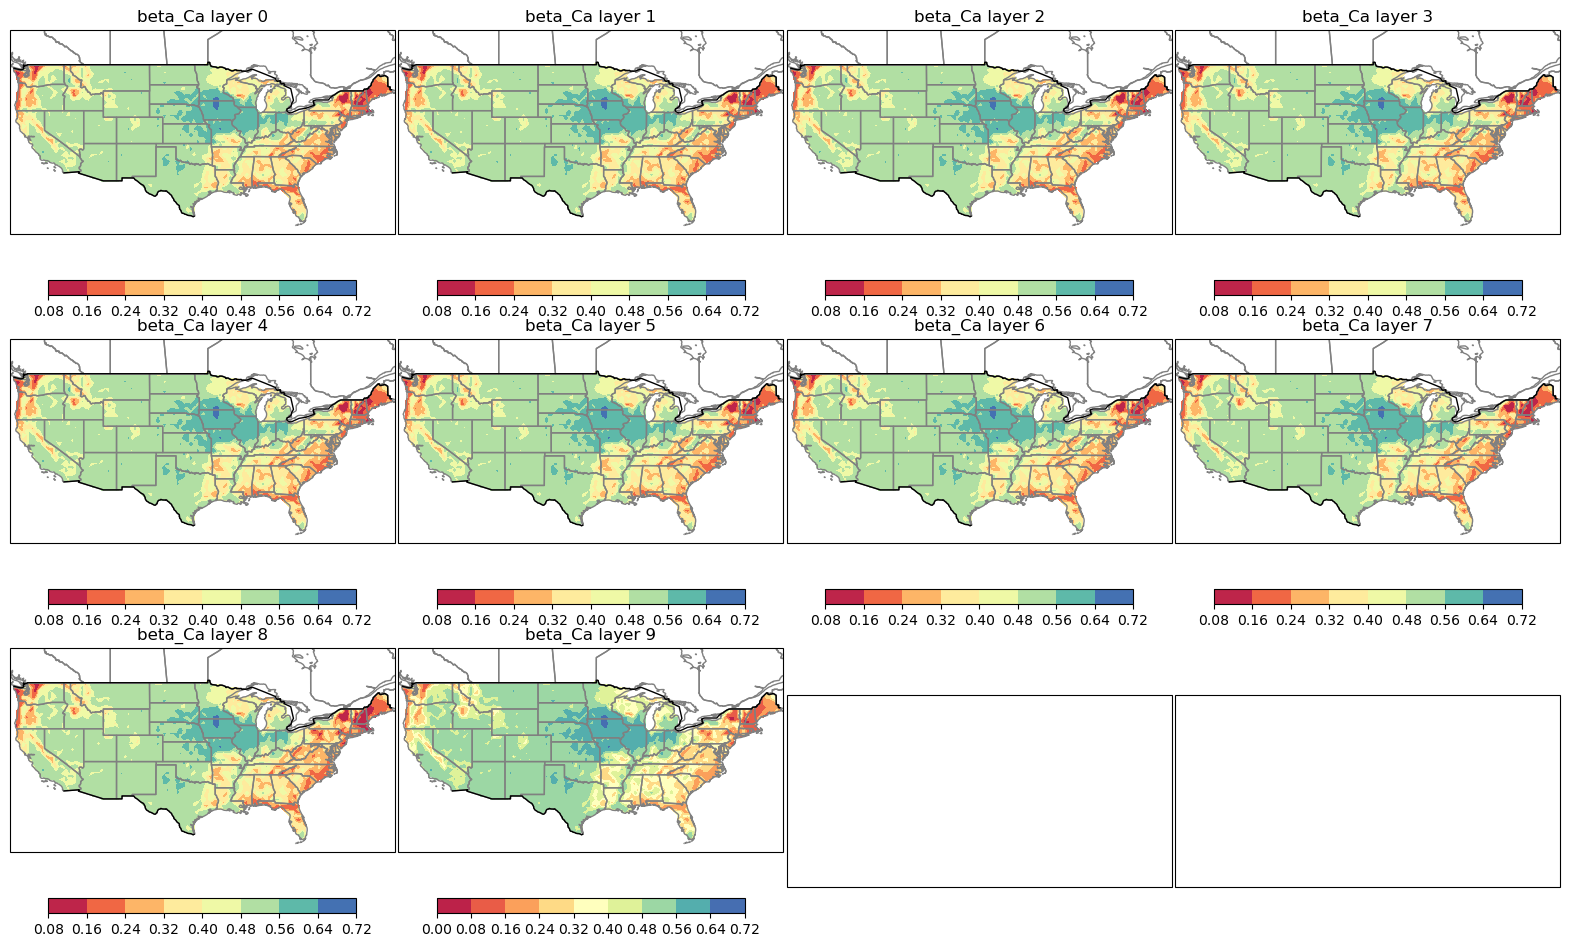

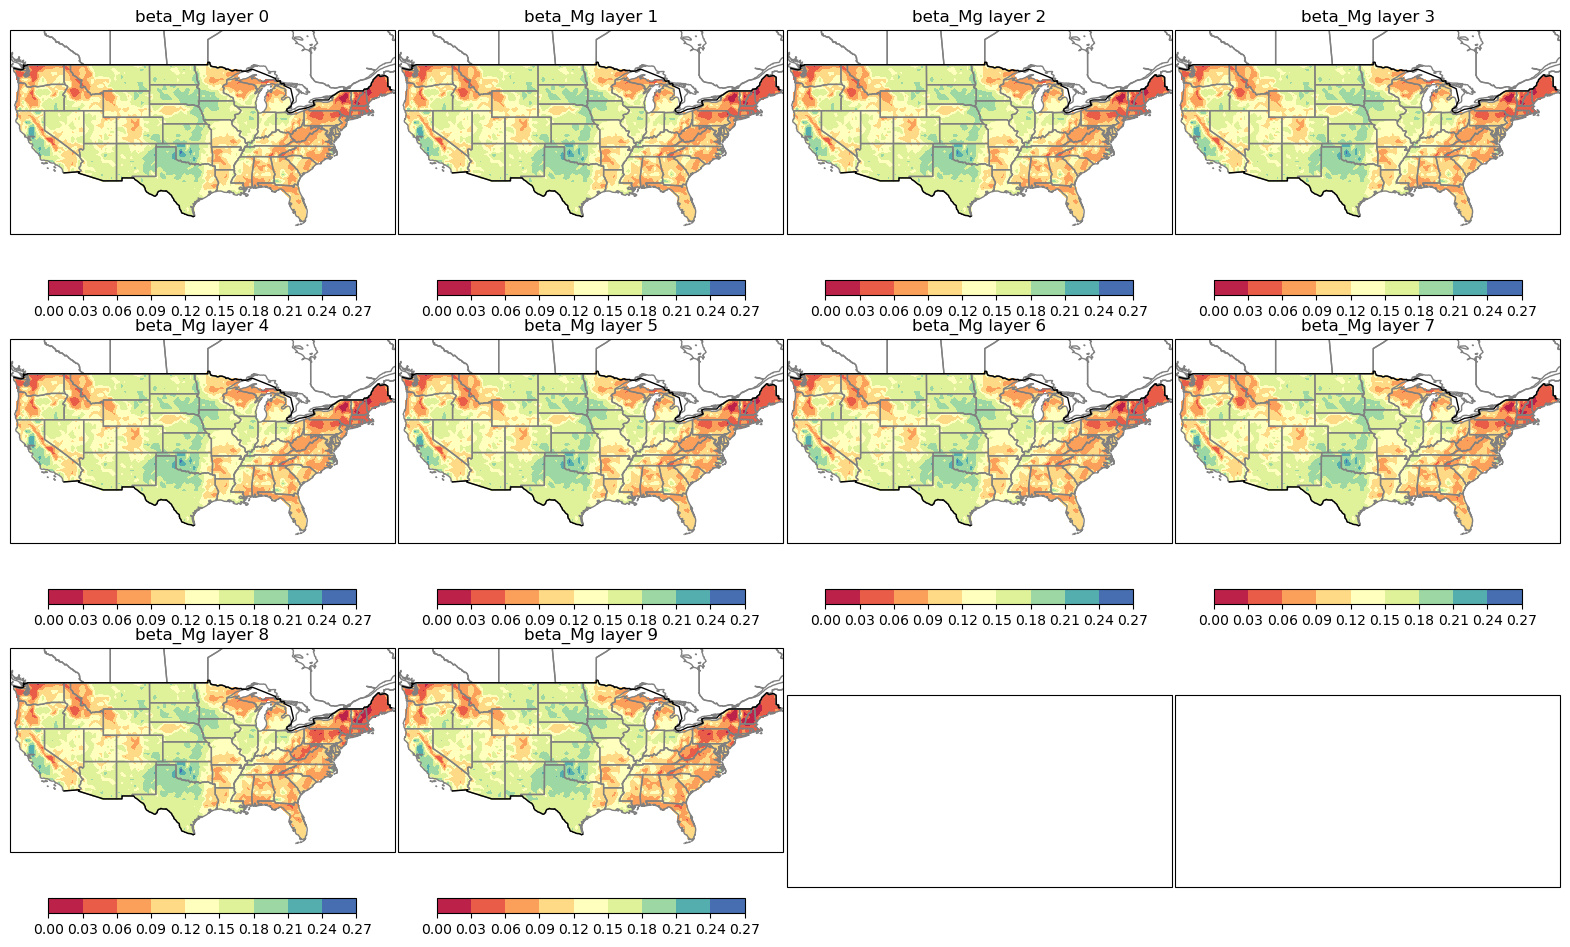

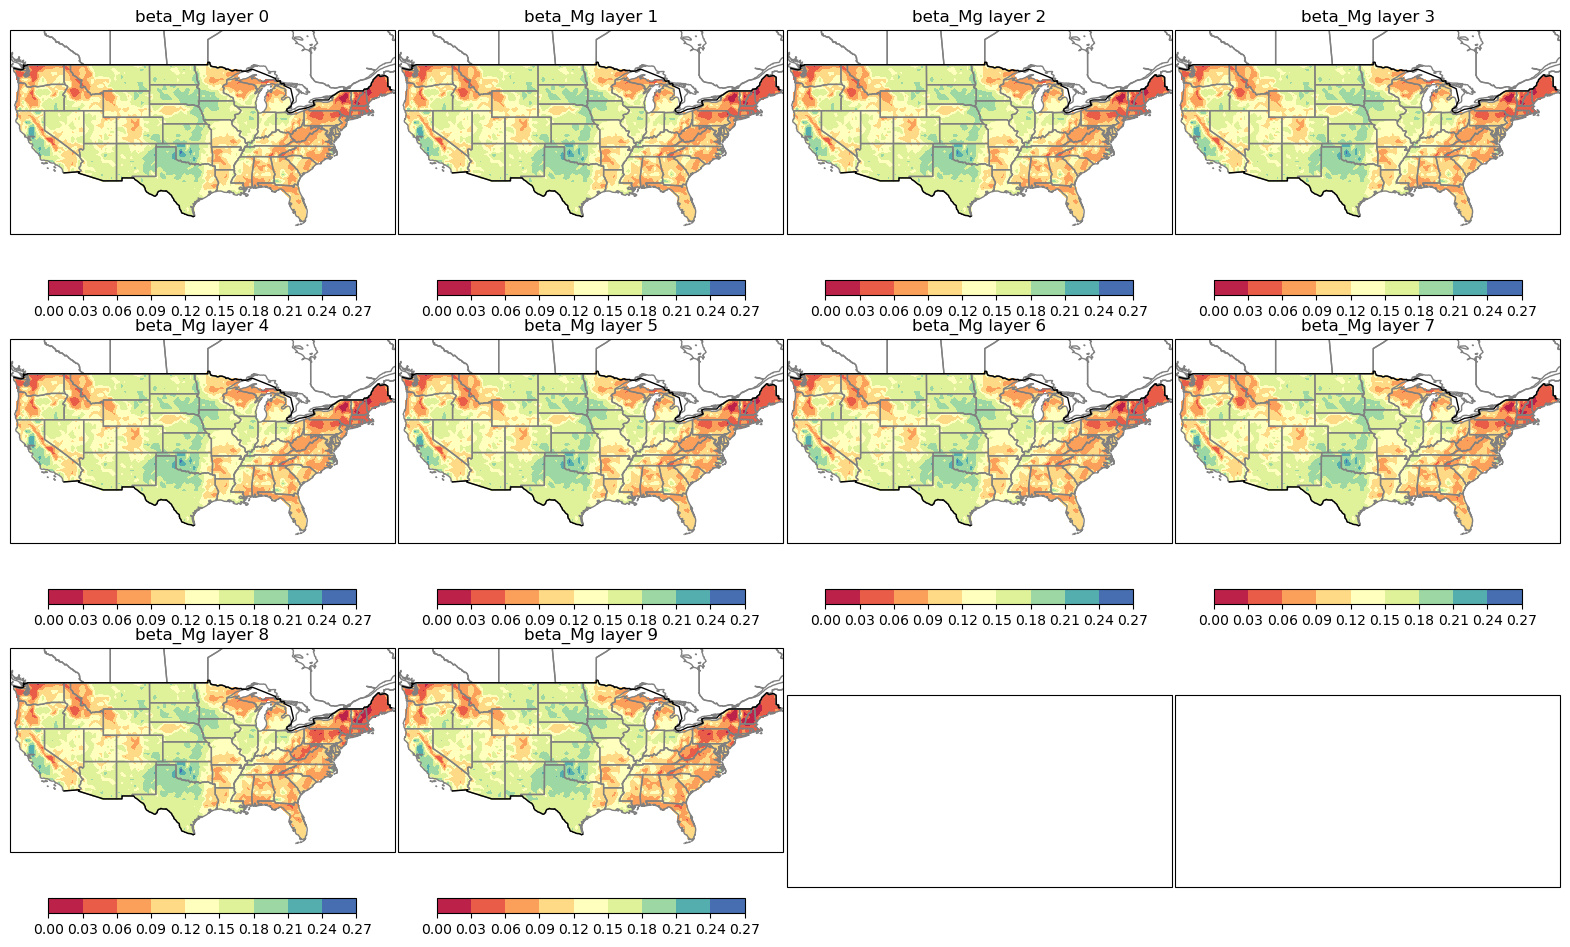

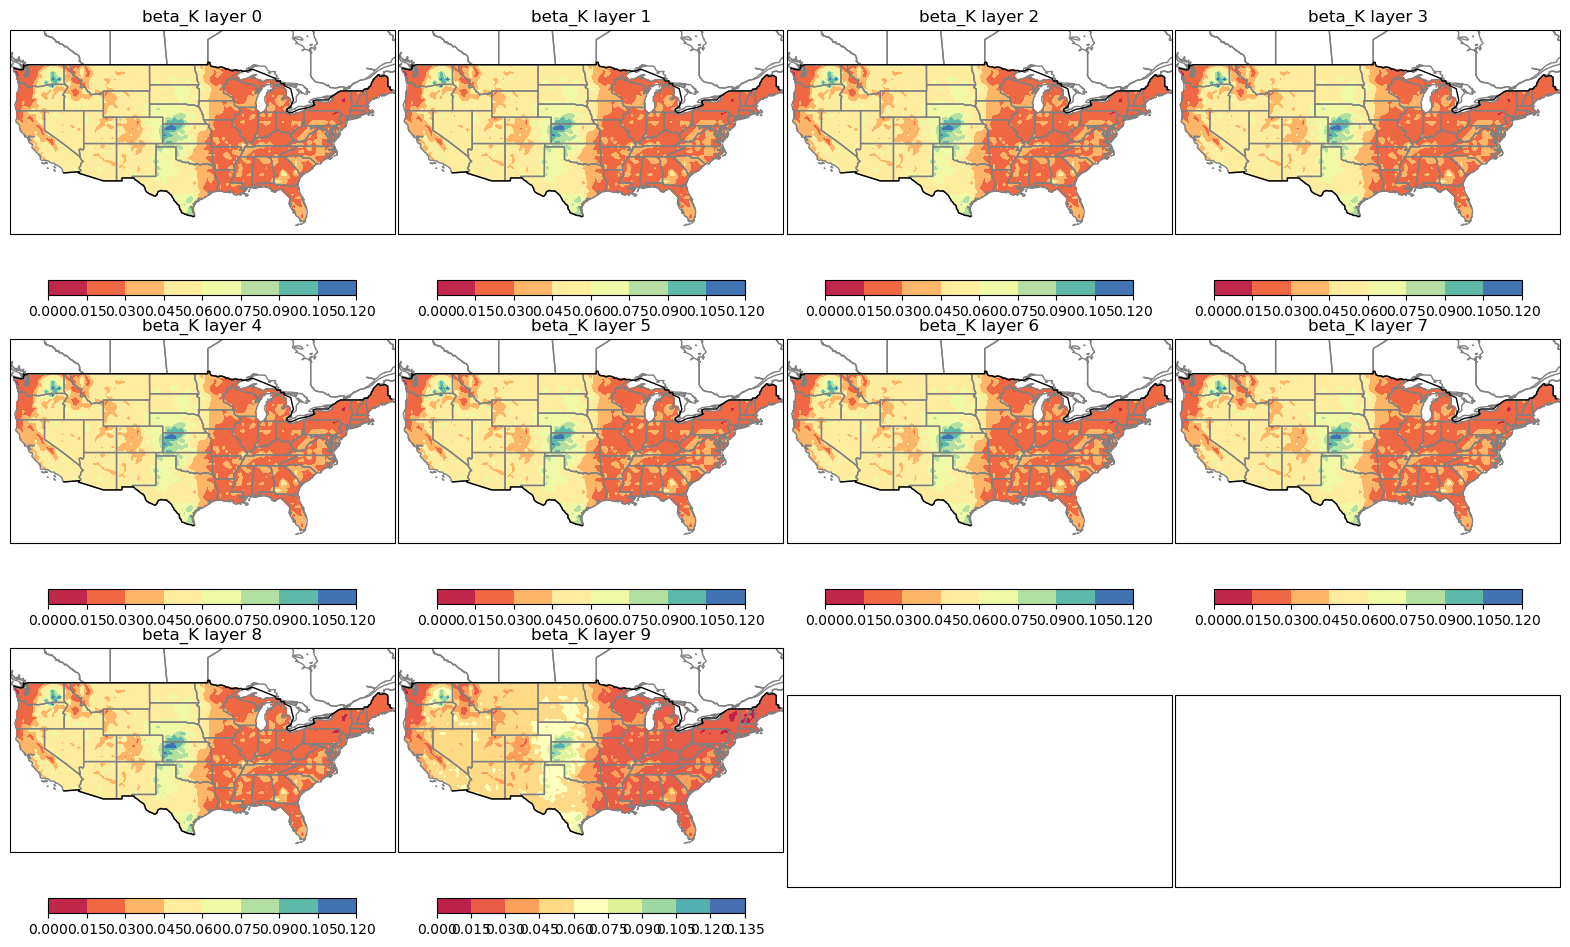

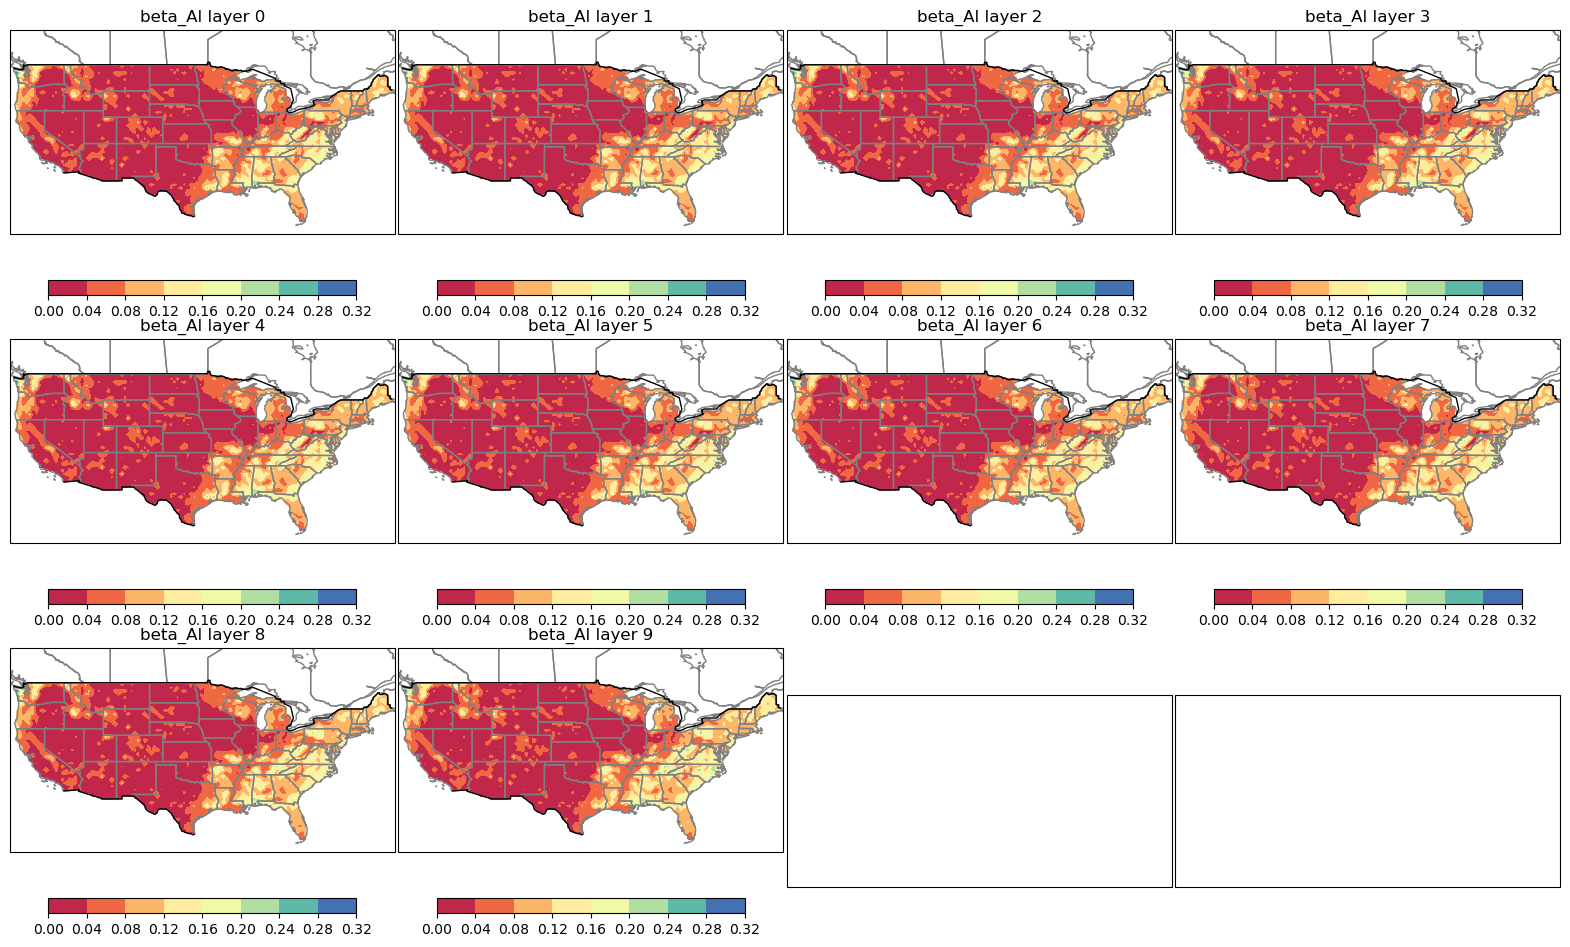

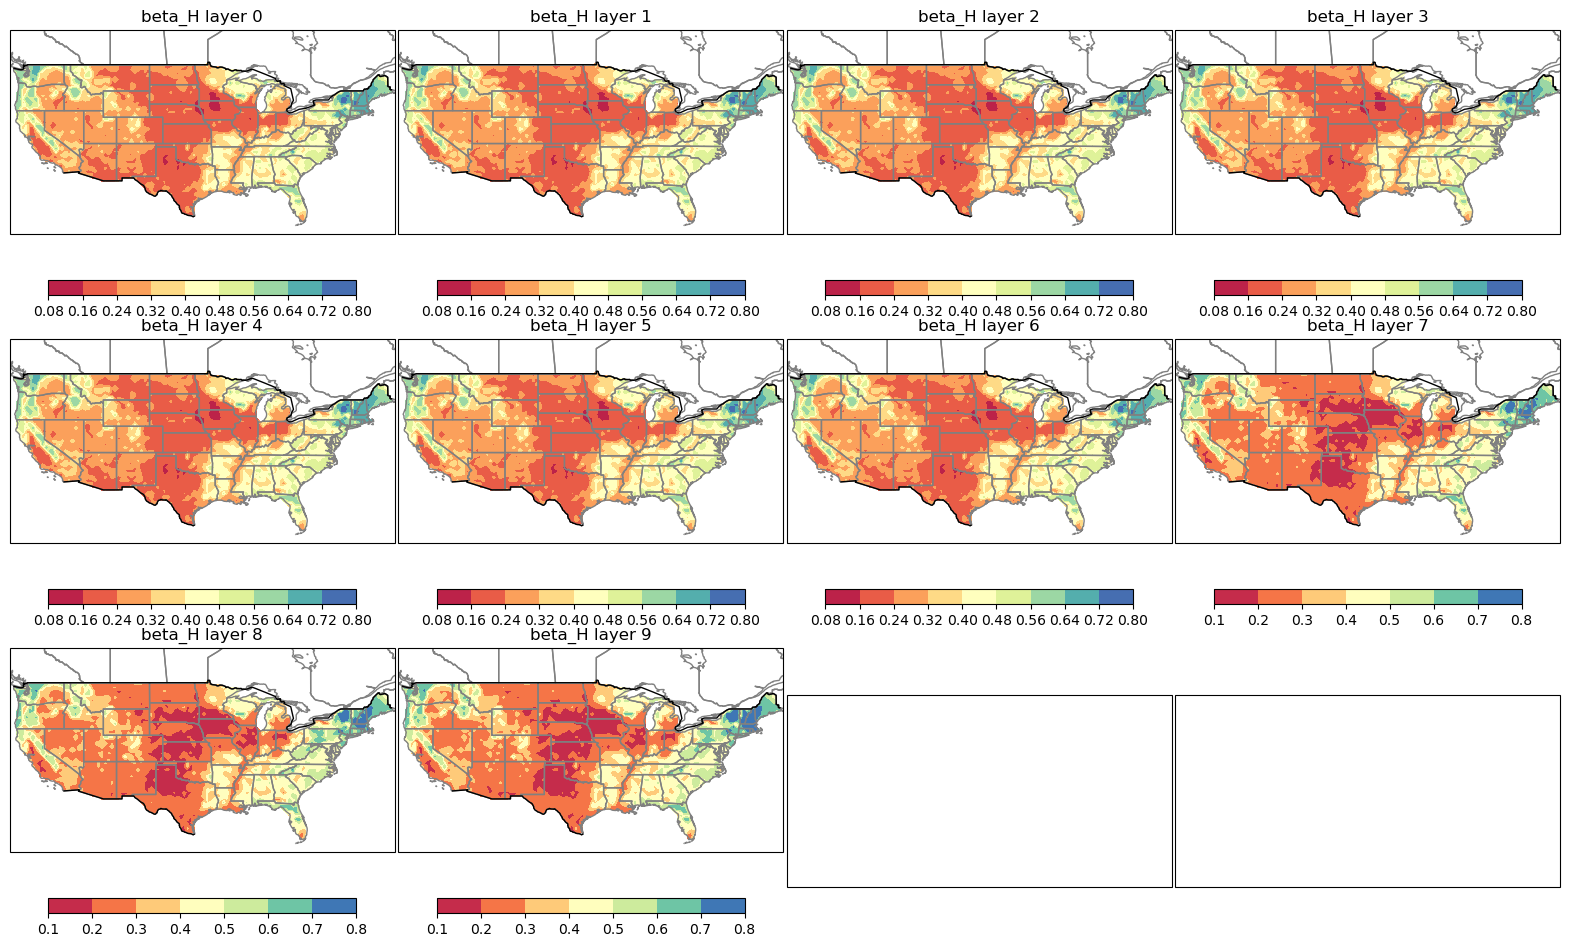

In [147]:
##################################################################################
# Double check the interpolated result
##################################################################################
hr = xr.open_dataset(os.path.join(os.environ['PROJDIR'], 'ERW_LDRD', 'results', 
                        f'RF_NCSS_filled_interp.nc'))

# (1) Make sure the sum of beta's are 1
for i in range(10):
    temp = (hr['beta_Ca'][i, :, :] + hr['beta_Mg'][i, :, :] + hr['beta_Na'][i, :, :] + hr['beta_K'][i, :, :] + hr['beta_Al'][i, :, :] + hr['beta_H'][i, :, :])
    print(np.nanmax(temp), np.nanmin(temp))

# (2) Plot the results
for val in ['beta_Ca', 'beta_Mg', 'beta_Mg', 'beta_K', 'beta_Al', 'beta_H']:
    fig, axes = plt.subplots(3, 4, figsize = (20, 12), 
                             subplot_kw={'projection': ccrs.PlateCarree()})
    fig.subplots_adjust(hspace = 0.01, wspace = 0.01)
    for layer in range(10):
        ax = axes.flat[layer]
        ax.add_feature(cfeature.STATES, edgecolor = 'grey')
        ax.add_feature(cfeature.BORDERS)
        cf = ax.contourf(hr['lon'], hr['lat'], hr[val][layer, :, :], cmap = 'Spectral')
        plt.colorbar(cf, ax = ax, orientation = 'horizontal', shrink = 0.8, aspect = 20)
        ax.set_title(f'{val} layer {layer}')

hr.close()